In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, brier_score_loss, confusion_matrix, log_loss
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('pitches')  # read pitches file using pandas

<strong>Phase 1: Exploratory Data Analysis</strong>

In [3]:
data.describe(include='all')

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,is_final_pitch,final_balls,final_strikes,final_outs,start_tfs,start_tfs_zulu,batter_id,stand,b_height,pitcher_id,p_throws,at_bat_des,event,event2,event3,event4,away_team_runs,home_team_runs,score,pitch_des,pitch_id,type,pitch_tfs,pitch_tfs_zulu,x,y,sv_id,start_speed,end_speed,sz_top,sz_bot,pfx_x,pfx_z,px,pz,x0,z0,y0,vx0,vz0,vy0,ax,az,ay,break_length,break_y,break_angle,pitch_type,type_confidence,zone,nasty,spin_dir,spin_rate,cc,on_1b,on_2b,on_3b,runner1_id,runner1_start,runner1_end,runner1_event,runner1_score,runner1_rbi,runner1_earned,runner2_id,runner2_start,runner2_end,runner2_event,runner2_score,runner2_rbi,runner2_earned,runner3_id,runner3_start,runner3_end,runner3_event,runner3_score,runner3_rbi,runner3_earned,runner4_id,runner4_start,runner4_end,runner4_event,runner4_score,runner4_rbi,runner4_earned,runner5_id,runner5_start,runner5_end,runner5_event,runner5_score,runner5_rbi,runner5_earned,runner6_id,runner6_start,runner6_end,runner6_event,runner6_score,runner6_rbi,runner6_earned,runner7_id,runner7_start,runner7_end,runner7_event,runner7_score,runner7_rbi,runner7_earned,created_at,added_at,modified_at,modified_by
count,7.189610e+05,718961.000000,718961.0,718961,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961,718961.000000,718961,718961,718961.000000,718961,718961,718961,8299,334,23,718961.000000,718961.000000,56096,718961,718961.000000,718961,718659.000000,718659,718961.000000,718961.000000,716681,716681.000000,716681.000000,716681.000000,716681.000000,716681.000000,716681.000000,716681.000000,716681.000000,716681.000000,716681.000000,716681.0,716681.000000,716681.000000,716681.000000,716681.000000,716681.000000,716681.000000,716681.000000,716681.000000,716681.000000,716681,716681.000000,716681.000000,716681.000000,716681.000000,716681.000000,27937,216323.000000,139703.000000,71635.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,718961,718961,718961,718961.0
unique,NaN,NaN,NaN,203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184905,NaN,2,18,NaN,2,129102,30,14,5,1,NaN,NaN,1,18,NaN,3,NaN,656363,NaN,NaN,646561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,23292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2397,2397,2397,NaN
top,NaN,NaN,NaN,2011-09-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000-00-00 00:00:00,NaN,R,6-2,NaN,R,Mark Reynolds strikes out swinging.,Strikeout,Error,Error,Error,NaN,NaN,T,Ball,NaN,S,NaN,2011-04-10 00:08:07,NaN,NaN,110821_141450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FF,NaN,NaN,NaN,NaN,NaN,"|pitcher| has his out pitch working today, rec...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 22:21:25,2016-03-03 22:21:25,2016-03-03 22:21:25,NaN
freq,NaN,NaN,NaN,5052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,NaN,407496,135198,NaN,525880,700,168261,2640,158,23,NaN,NaN,56096,245007,NaN,318295,NaN,119,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238541,NaN,NaN,NaN,NaN,NaN,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

It is important to get an idea of the distribution of the target feature, so we create a simple bar chart to visualize this. It is clear that we have a few classes that have low relative frequencies.

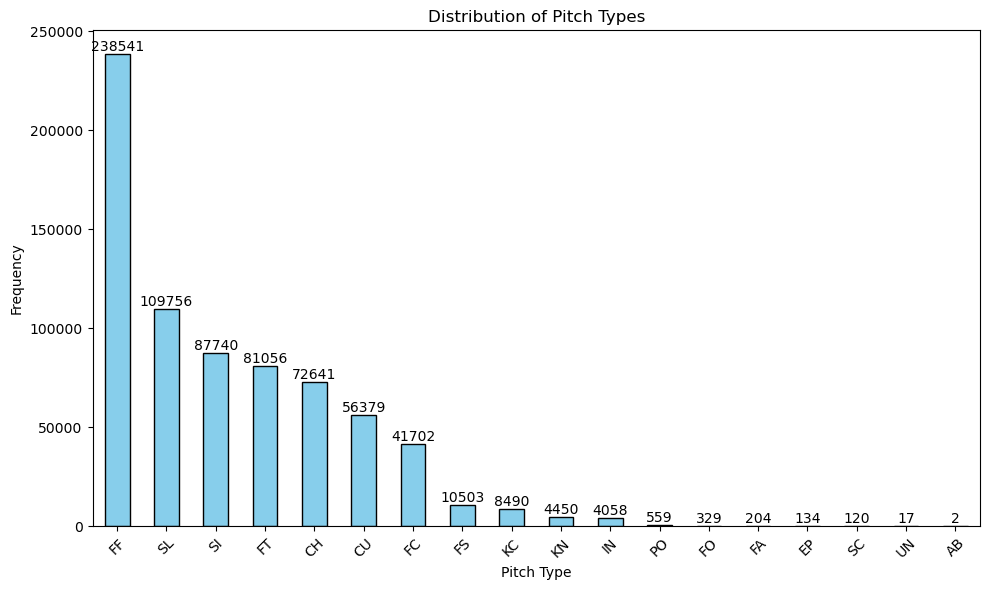

In [4]:
# Calculate the frequency of each pitch type
pitch_type_counts = data['pitch_type'].value_counts()

# Plot bar plot for the distribution of "pitch_type"
plt.figure(figsize=(10, 6))
bars = pitch_type_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add data labels
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, str(int(bar.get_height())), ha='center', va='bottom')

plt.title('Distribution of Pitch Types')
plt.xlabel('Pitch Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

<strong>Phase 2: Feature Engineering</strong>

Based on the description table above and conventional baseball intuition, we can choose fields that we believe will have predictive value.

In [5]:
data = data[['game_pk', 'batter_id', 'inning', 'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes', 'fouls', 'outs',
             'away_team_runs', 'home_team_runs', 'on_1b', 'on_2b', 'on_3b', 'stand', 'p_throws', 'pitcher_id', 'pitch_type']]

Firstly, we will drop the AB pitches from the dataset. With only 2 samples (<0.0002%) in this class, it will throw off future cross-validation and is so infrequent that we will not attempt to combine it with other classes arbitrarily. Ideally, the AB pitches would be combined with the most similar class, but there is no way to know that with no descriptions of pitch type abbreviations.

In [6]:
data = data[data.pitch_type != "AB"]

Secondly, baseball intuition would say that the predictive value in the handedness of the batter and pitcher, in isolation, are negligible, however we can combine them to create a new feature which tracks whether or not the pitcher and batter possess the same handedness, which is far more likely to be predictive. Situations where the pitcher and batter have the opposite handedness should increase the likelihood of offspeed pitches as batters typically have an easier time seeing the ball out of the hand of the pitcher.

In [7]:
data['same_stance_throw'] = (data['stand'] == data['p_throws']).astype(int) # Create a new column named 'same_stance_throw' with value 1 if 'stand' matches 'p_throws', else 0
data = data.drop(['stand', 'p_throws'], axis=1) # Drop the original 'stand' and 'p_throws' columns

Thirdly, we can simplify the on-base tracker features by converting them to binaries - in this analysis, the specific player on base doesn't matter as much as knowing if there is any player on that base or not. Players being on base should decrease the likelihood of off-speed pitches as the pitcher will want to prevent players from stealing bases behind him.

In [8]:
data['on_1b'] = data['on_1b'].notna().astype(int)
data['on_2b'] = data['on_2b'].notna().astype(int)
data['on_3b'] = data['on_3b'].notna().astype(int)

Fourthly, perhaps the best predictor of pitch type is the pitcher's tendencies. Most pitchers, particularly relievers, only have 2 or 3 pitches that they can rely on and therefore only throw those 2 or 3 pitches the vast majority of the time. We can synthesize a series of running average features to track these tendencies based on past pitches. However, given memory and computing power constraints, we will only utilize the fastball tendency as that is the most common pitch.

In [9]:
data = data.dropna(axis=0)

# Loop through unique pitch types and calculate running totals for each pitcher
for pitch_type in data['pitch_type'].unique():
    if pitch_type == 'FF':
        mask = data['pitch_type'] == pitch_type  # Create a boolean mask for the current pitch type

        # Calculate cumulative count of pitches for each pitch type, adjusting the counting to ignore the current row for each pitcher id
        data[pitch_type + '_tendency'] = (mask.groupby(data['pitcher_id']).cumsum() - mask.astype(int))

# Convert counts to percentages, but only if 'FF_tendency' exists in the dataframe
if 'FF_tendency' in data.columns:
    for pitcher_id in data['pitcher_id'].unique():
        total_pitcher = data.loc[data['pitcher_id'] == pitcher_id, 'FF_tendency'].sum()
        data.loc[data['pitcher_id'] == pitcher_id, 'FF_tendency'] /= total_pitcher

    data.fillna(0, inplace=True)  # Replace NaN values resulting from division by zero with 0
    print(data['FF_tendency'].describe())
else:
    print("No 'FF' pitch type found in the data.")

count    716679.000000
mean          0.000872
std           0.002280
min           0.000000
25%           0.000200
50%           0.000454
75%           0.000894
max           0.428571
Name: FF_tendency, dtype: float64


Lastly, we can convert the pitch_count feature to something likely more predictive: times_through_rotation. Baseball intuition would say that most (starting) pitchers attempt to rely on only one or two pitches the first time through the rotation, and start to use more pitches from deeper in their arsenal after that.

In [10]:
data['times_through_rotation'] = data.groupby(['game_pk', 'pitcher_id'])['batter_id'].transform(lambda x: x.ne(x.shift().fillna(x)).cumsum())//9
data = data.drop(['pcount_pitcher'], axis=1) # drop the original pitch count column
print(data[['times_through_rotation']].describe())

       times_through_rotation
count           716679.000000
mean                 0.652667
std                  0.839599
min                  0.000000
25%                  0.000000
50%                  0.000000
75%                  1.000000
max                  4.000000


<strong>Phase 3: ML Prep and Model Selection</strong>

In this section, we will prepare the dataset for use in various classification models.

In [11]:
# Drop rows with any missing values
data = data.dropna(axis=0)

# Prepare feature matrix X by dropping columns that won't be used as features
# 'pitch_type' is the target variable, 'pitcher_id', 'batter_id', and 'game_pk' are identifiers
X = data.drop(['pitch_type', 'pitcher_id', 'batter_id', 'game_pk'], axis=1)

# Prepare target variable y by converting 'pitch_type' to uppercase
y = data['pitch_type'].str.upper()

# Initialize the standard scaler
scaler = StandardScaler()

# Scale the feature data, excluding 'pitch_type'
scaled_data = scaler.fit_transform(data.drop("pitch_type", axis=1))

# Convert scaled data back to DataFrame with appropriate column names
scaled_data = pd.DataFrame(scaled_data, columns=data.columns.drop("pitch_type"))

# Update the original dataset by concatenating the scaled features with the 'pitch_type' column
data = pd.concat([scaled_data, data["pitch_type"]], axis=1)

# Split the data into training and testing sets
# Use 20% of the data for testing and the remaining 80% for training
# 'random_state=42' ensures reproducibility of the results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now, we will test out various types of classifiers to see which model type performs the best on our dataset. We will use Brier Loss as the primary evaluation metric throughout the rest of the analysis. Brier Loss is a good method of measuring the quality of class predicted probabilities (as opposed to a standard metric, such as accuracy, which can only measure binary predictions).

In [12]:
# Define the classifiers
classifiers = [
    KNeighborsClassifier(n_neighbors=10),
    GaussianNB(),
    RandomForestClassifier(),
    LogisticRegression()
]

# Initialize variables to keep track of the best classifier and its score
best_classifier = None
best_brier_score = float('inf')  # Initialize with a large value

# Iterate over the classifiers
for clf in classifiers:
    # Fit the base classifier
    clf.fit(X_train, y_train)
    
    # Generate predicitions with classifier
    y_pred = clf.predict_proba(X_test)
    
    # Compute Brier Score Loss for each class separately
    brier_score = [brier_score_loss(y_test == c, y_pred[:, i]) for i, c in enumerate(clf.classes_)]
    
    # Average the Brier Score Loss across all classes
    average_brier_loss = np.mean(brier_score)
    
    # Update the best classifier if the current one has a lower Brier Score
    if average_brier_loss < best_brier_score:
        best_brier_score = average_brier_loss
        best_classifier = clf
        
    print(clf, ":", average_brier_loss)

print("\nBest Classifier:", best_classifier)
print("Best Brier Score Loss:", best_brier_score)

KNeighborsClassifier(n_neighbors=10) : 0.04928604611460033
GaussianNB() : 0.05059160196686425
RandomForestClassifier() : 0.05039989674552094
LogisticRegression() : 0.04750737272667299

Best Classifier: LogisticRegression()
Best Brier Score Loss: 0.04750737272667299


Based on the results of this analysis, we will use a Logistic Regression model as it showed the lowest Brier Loss of the four mdoel types.

<strong>Phase 4: Model Calibration and Hyperparameter Tuning</strong>

In this phase, we will fine-tune a Logistic Regression model through both calibration and hyperparameter tuning.

Important note: Stratified K-fold cross-validation is used due to the relative infrequency of some of the pitch classes in the dataset. This type of cross-validation will help preserve the percentage of samples for each class.

In [13]:
# Define the hyperparameters grid for the best classifier
param_grid = {
    'calibrated_clf__base_estimator__C': [0.1, 1],  # Regularization parameter
    'calibrated_clf__base_estimator__solver': ['liblinear', 'newton-cg'],  # Solver for optimization
}

    
# Create a pipeline with scaling and calibration
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('calibrated_clf', CalibratedClassifierCV(best_classifier, method='sigmoid', cv=StratifiedKFold(n_splits=3))),
])

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=3), n_jobs=-1, verbose=4, error_score=1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict probabilities on the test set
y_pred_proba = best_model.predict_proba(X_test)

# Compute Brier Score Loss
brier_score = [brier_score_loss(y_test == c, y_pred_proba[:, i]) for i, c in enumerate(best_model.classes_)]
brier_score_avg = np.mean(brier_score)

# Calculate model improvement
improvement = 100*abs(brier_score_avg-best_brier_score)/best_brier_score

print("Best Hyperparameters:", grid_search.best_params_)
print("New Brier Score Loss:", brier_score_avg)
print(f"Model improvement as a result of tuning and calibration: {improvement}%")

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_spar

/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_spar

[CV 2/3] END calibrated_clf__base_estimator__C=1, calibrated_clf__base_estimator__solver=liblinear;, score=0.332 total time= 3.8min


/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


[CV 2/3] END calibrated_clf__base_estimator__C=0.1, calibrated_clf__base_estimator__solver=newton-cg;, score=0.334 total time= 7.1min
[CV 3/3] END calibrated_clf__base_estimator__C=0.1, calibrated_clf__base_estimator__solver=newton-cg;, score=0.334 total time= 7.2min
[CV 1/3] END calibrated_clf__base_estimator__C=0.1, calibrated_clf__base_estimator__solver=newton-cg;, score=0.334 total time= 7.2min
[CV 2/3] END calibrated_clf__base_estimator__C=0.1, calibrated_clf__base_estimator__solver=liblinear;, score=0.332 total time= 3.3min
[CV 3/3] END calibrated_clf__base_estimator__C=1, calibrated_clf__base_estimator__solver=liblinear;, score=0.332 total time= 4.0min


/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/swagner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


[CV 1/3] END calibrated_clf__base_estimator__C=0.1, calibrated_clf__base_estimator__solver=liblinear;, score=0.332 total time= 3.3min
[CV 1/3] END calibrated_clf__base_estimator__C=1, calibrated_clf__base_estimator__solver=newton-cg;, score=0.334 total time= 9.5min
[CV 1/3] END calibrated_clf__base_estimator__C=1, calibrated_clf__base_estimator__solver=liblinear;, score=0.333 total time= 3.7min
[CV 3/3] END calibrated_clf__base_estimator__C=1, calibrated_clf__base_estimator__solver=newton-cg;, score=0.334 total time= 8.2min
[CV 3/3] END calibrated_clf__base_estimator__C=0.1, calibrated_clf__base_estimator__solver=liblinear;, score=0.332 total time= 3.4min
[CV 2/3] END calibrated_clf__base_estimator__C=1, calibrated_clf__base_estimator__solver=newton-cg;, score=0.334 total time= 9.3min
Best Hyperparameters: {'calibrated_clf__base_estimator__C': 0.1, 'calibrated_clf__base_estimator__solver': 'newton-cg'}
New Brier Score Loss: 0.047259241258683686
Model improvement as a result of tuning a

<strong>Phase 5: Evaluation</strong>

Final Brier Loss 0.047259241258683686
Accuracy based on max predicted probability: 0.3346333091477368


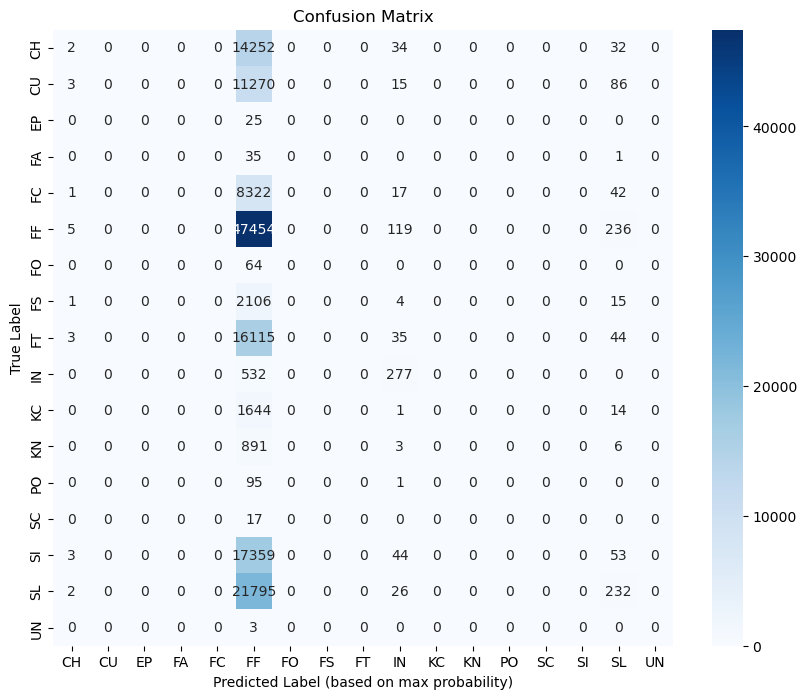

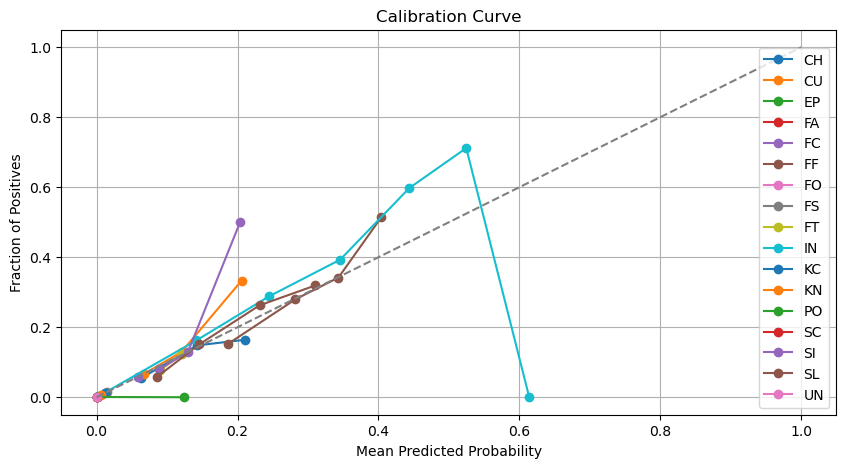

In [14]:
print("Final Brier Loss", brier_score_avg)

# Get the predicted class labels based on the maximum predicted probability
y_pred_max_prob_index = np.argmax(y_pred_proba, axis=1)
y_pred_max_prob = best_model.classes_[y_pred_max_prob_index]

# Calculate metrics based on the maximum predicted probability
accuracy_max_prob = np.mean(y_pred_max_prob == y_test)
print("Accuracy based on max predicted probability:", accuracy_max_prob)

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_max_prob, labels=best_model.classes_)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label (based on max probability)')
plt.ylabel('True Label')
plt.show()

# Plot calibration curve for each class
plt.figure(figsize=(10, 5))
for i in range(len(best_model.classes_)):
    prob_true, prob_pred = calibration_curve(y_test == best_model.classes_[i], y_pred_proba[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=best_model.classes_[i])

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

Overall findings:

Brier Loss: The model's low Brier Loss indicates that the predicted probabilities from the model align closely with the actual outcomes. In other words, the model's predictions are well-calibrated, meaning that when it assigns a high probability to an event, that event tends to occur frequently, and vice versa. This is a desirable characteristic for predictive models because it reflects their ability to provide accurate and reliable probability estimates. A low Brier Score signifies the model's effectiveness in quantifying uncertainty and can instill confidence in its predictions, making it a valuable tool for decision-making in various domains, such as risk assessment, classification, and forecasting.

Well-calibrated start: A well-calibrated curve at the beginning indicates that, on average, the predicted probabilities align well with the true fraction of positives for low-confidence predictions. This means that when the model predicts low probabilities, it tends to be correct on average.

Deviation towards the end: A deviation from perfect calibration towards the end of the curve suggests that the model's predicted probabilities become less reliable as they approach 1. This indicates that when the model predicts high probabilities, it may overestimate the likelihood of the event occurring for these particular classes.

Implications: The deviation towards the end of the curve could indicate that the model is overly confident in its predictions for certain classes. It may be assigning higher probabilities than warranted by the true frequency of positive outcomes. This could lead to potentially misleading predictions, especially for high-confidence predictions.

In summary, while a well-calibrated start of the curve is promising, the deviation towards the end suggests room for improvement, particularly in the model's calibration for high-confidence predictions for those specific classes. In the future, we should investigate the underlying reasons for this deviation and take appropriate actions can help improve the model's performance and reliability.

Future Considerations:

There exists significant potential for further refinement and enhancement of this analysis, particularly in the realms of feature engineering and model optimization. Regarding feature engineering, a broader exploration beyond solely leveraging fastball tendency could yield valuable insights. Integrating additional datasets focusing on batters and baserunners could provide a comprehensive understanding of their strengths and weaknesses, enabling the identification of strategic opportunities for pitchers. For instance, identifying batters with a propensity for fastball anticipation could inform pitching strategies, prompting a shift towards offspeed pitches.

In terms of model optimization, given expanded computational resources and memory capacity, there is an opportunity to explore a wider array of model types. Expanding the hyperparameter grid search beyond its current scope could unveil additional nuances in model performance, leading to further refinements and potentially improved predictive capabilities.